# Variational Benchmarking of a 2‑Qubit Light–Matter Hamiltonian (Local + IBM Quantum)

This notebook demonstrates:
- **Local (noiseless) benchmarking** of a small light–matter Hamiltonian using a variational ansatz.
- **Local noise studies** (Aer depolarizing + readout error) to show sensitivity of variational energies.
- **Real-hardware benchmarking** on an **IBM Quantum** backend, comparing **raw** vs **mitigated** execution against exact energies, including a small runtime comparison.

**Model (2 qubits):**
$H(g)=\frac{\omega_c}2\,ZI + \frac{\omega_e}2\,IZ + g\,XX$

Convention: `Pauli("ZI")` acts as $Z\otimes I$ on $q_1\otimes q_0$.


In [1]:
# ============================
# Global style + helpers
# ============================

import os, json
import numpy as np
import matplotlib.pyplot as plt

# Consistent colors throughout
COLOR_A   = "blue"    # Ansatz A / local variational
COLOR_B   = "orange"  # Ansatz B / richer ansatz
COLOR_HW  = "red"     # IBM hardware
COLOR_EX  = "black"   # Exact reference

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(name, dpi=200):
    # Save the current figure to FIG_DIR with tight bounding box
    path = os.path.join(FIG_DIR, name)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print("Saved:", path)

print("Ready. Figures will be saved to:", FIG_DIR)


Ready. Figures will be saved to: figures


In [2]:
# ============================
# Imports (Qiskit)
# ============================

from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector

# Local (Aer) estimator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

print("Imported Qiskit + Aer EstimatorV2.")


Imported Qiskit + Aer EstimatorV2.


In [3]:
# ============================
# Model definition: operators + exact ground energy
# ============================

# Hamiltonian terms
ZI = Pauli("ZI")
IZ = Pauli("IZ")
XX = Pauli("XX")
OPS = [ZI, IZ, XX]
OP_NAMES = ["ZI", "IZ", "XX"]

def exact_ground_energy(g: float, wc: float = 1.0, we: float = 1.0):
    # Exact diagonalization for H = (wc/2) ZI + (we/2) IZ + g XX
    # using the same ordering convention as Pauli strings (q1 ⊗ q0).

    I = np.eye(2, dtype=complex)
    X = np.array([[0,1],[1,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)

    ZI_mat = np.kron(Z, I)
    IZ_mat = np.kron(I, Z)
    XX_mat = np.kron(X, X)

    H = 0.5*wc*ZI_mat + 0.5*we*IZ_mat + g*XX_mat
    evals, _ = np.linalg.eigh(H)
    return float(np.min(evals)), evals

print("Operators:", OP_NAMES)
print("Exact ground energy at g=0.6:", exact_ground_energy(0.6)[0])


Operators: ['ZI', 'IZ', 'XX']
Exact ground energy at g=0.6: -1.16619037896906


In [5]:
# ============================
# Ansatz definitions
# ============================

def ansatz_A(theta: float) -> QuantumCircuit:
    # Ansatz A: 1 parameter
    qc = QuantumCircuit(2)
    qc.ry(theta, 0)
    qc.cx(0, 1)
    return qc

def ansatz_B(theta0: float, theta1: float) -> QuantumCircuit:
    # Ansatz B: 2 parameters (slightly richer)
    qc = QuantumCircuit(2)
    qc.ry(theta0, 0)
    qc.ry(theta1, 1)
    qc.cx(0, 1)
    return qc


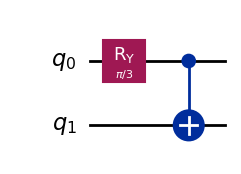

In [6]:
# quick visualization
ansatz_A(np.pi/3).draw("mpl")

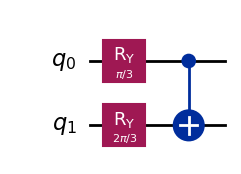

In [7]:
# quick visualization
ansatz_B(np.pi/3, 2.0*np.pi/3).draw("mpl")

In [9]:
# ============================
# Local (noiseless) energy evaluation using Aer EstimatorV2
# ============================

local_estimator = AerEstimator()

def evs_for_circuit_local(qc: QuantumCircuit):
    job = local_estimator.run([(qc, OPS)])
    res = job.result()[0]
    return res.data.evs  # [<ZI>, <IZ>, <XX>] in OPS order

def energy_from_evs(evs, g: float, wc: float = 1.0, we: float = 1.0) -> float:
    exp_ZI, exp_IZ, exp_XX = [float(x) for x in evs]
    return float(0.5*wc*exp_ZI + 0.5*we*exp_IZ + g*exp_XX)

def energy_A_local(theta: float, g: float, wc: float = 1.0, we: float = 1.0) -> float:
    qc = ansatz_A(theta)
    return energy_from_evs(evs_for_circuit_local(qc), g=g, wc=wc, we=we)

def energy_B_local(theta0: float, theta1: float, g: float, wc: float = 1.0, we: float = 1.0) -> float:
    qc = ansatz_B(theta0, theta1)
    return energy_from_evs(evs_for_circuit_local(qc), g=g, wc=wc, we=we)

print("Sanity check")
print("Energy from Ansatz A:", energy_A_local(theta=0.3, g=0.4))

Sanity check
Energy from Ansatz A: 1.0735445717901417


Saved: figures/01_local_Emin_vs_g_ansatzA.png


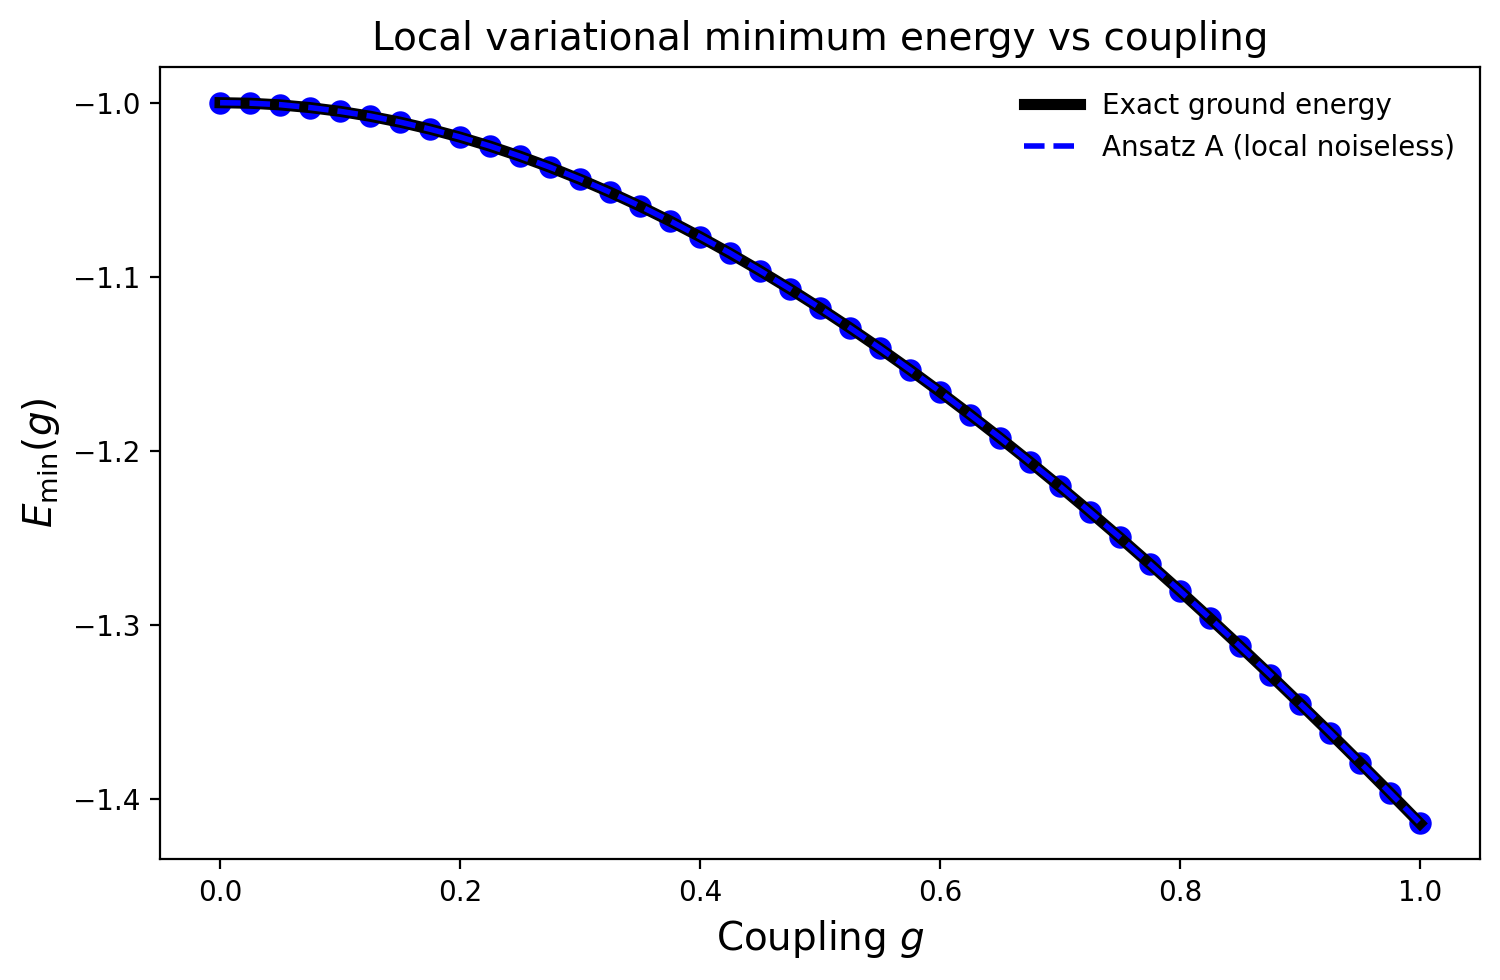

Saved: figures/02_local_thetaStar_vs_g_ansatzA.png


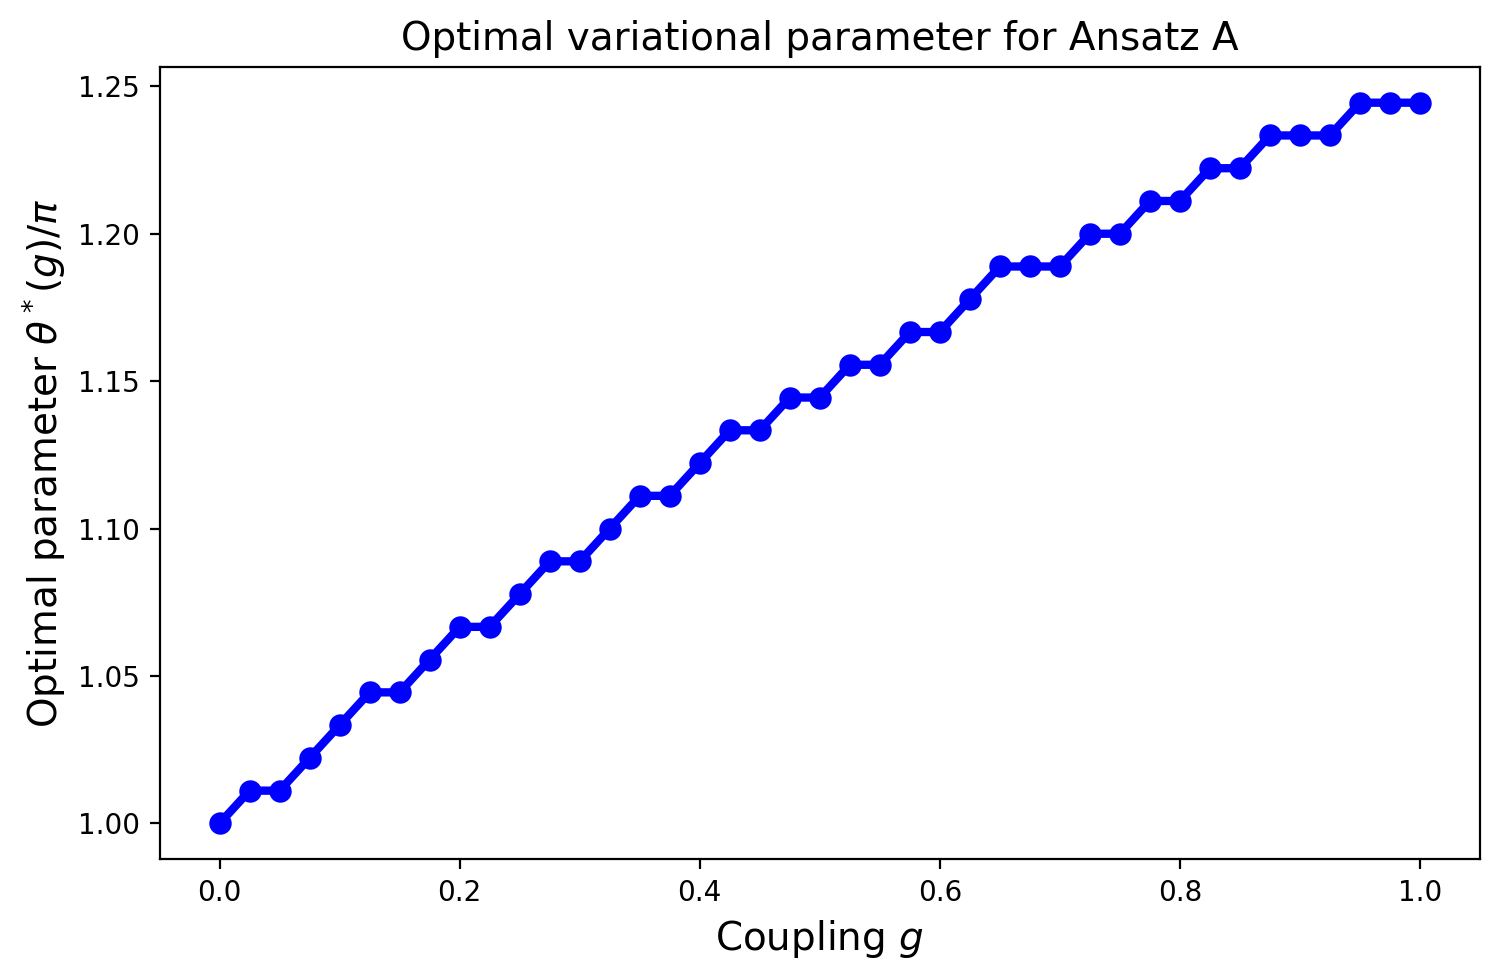

In [13]:
# ============================
# Variational minimum Emin(g) for Ansatz A
# ============================

wc, we = 1.0, 1.0

g_grid = np.linspace(0.0, 1.0, 41)
theta_grid = np.linspace(0, 2*np.pi, 181)

Emin_A = np.zeros_like(g_grid)
theta_star_A = np.zeros_like(g_grid)

for i, g in enumerate(g_grid):
    Evals = np.array([energy_A_local(th, g=g, wc=wc, we=we) for th in theta_grid])
    idx = int(np.argmin(Evals))
    Emin_A[i] = float(Evals[idx])
    theta_star_A[i] = float(theta_grid[idx])

E_exact_grid = np.array([exact_ground_energy(g, wc=wc, we=we)[0] for g in g_grid])

plt.figure(figsize=(7.6, 5.0), dpi=200)
plt.plot(g_grid, E_exact_grid, lw=4, ls="-", color=COLOR_EX, label="Exact ground energy")
plt.plot(g_grid, Emin_A, lw=2, ls='--', color=COLOR_A, label="Ansatz A (local noiseless)")
plt.scatter(g_grid, Emin_A, s=50, color=COLOR_A)
plt.xlabel(r"Coupling $g$", fontsize=14)
plt.ylabel(r"$E_{\min}(g)$", fontsize=14)
plt.title("Local variational minimum energy vs coupling", fontsize=14)
plt.legend(frameon=False)
plt.tight_layout()
savefig("01_local_Emin_vs_g_ansatzA.png")
plt.show()

plt.figure(figsize=(7.6, 5.0), dpi=200)
plt.plot(g_grid, theta_star_A/np.pi, lw=3, color=COLOR_A)
plt.scatter(g_grid, theta_star_A/np.pi, s=50, color=COLOR_A)
plt.xlabel(r"Coupling $g$", fontsize=14)
plt.ylabel(r"Optimal parameter $\theta^*(g)/\pi$", fontsize=14)
plt.title("Optimal variational parameter for Ansatz A", fontsize=14)
plt.tight_layout()
savefig("02_local_thetaStar_vs_g_ansatzA.png")
plt.show()


In [15]:
# ============================
# Ansatz comparison: 1-parameter vs 2-parameter (coarse grid search)
# ============================

g_grid_cmp = np.linspace(0.0, 1.0, 21)
theta0_grid = np.linspace(0, 2*np.pi, 41)
theta1_grid = np.linspace(0, 2*np.pi, 41)

Emin_B = np.zeros_like(g_grid_cmp)

for i, g in enumerate(g_grid_cmp):
    best_E = np.inf
    for t0 in theta0_grid:
        for t1 in theta1_grid:
            E = energy_B_local(t0, t1, g=g, wc=wc, we=we)
            if E < best_E:
                best_E = float(E)
    Emin_B[i] = best_E


Saved: figures/03_local_Emin_vs_g_ansatz_compare.png


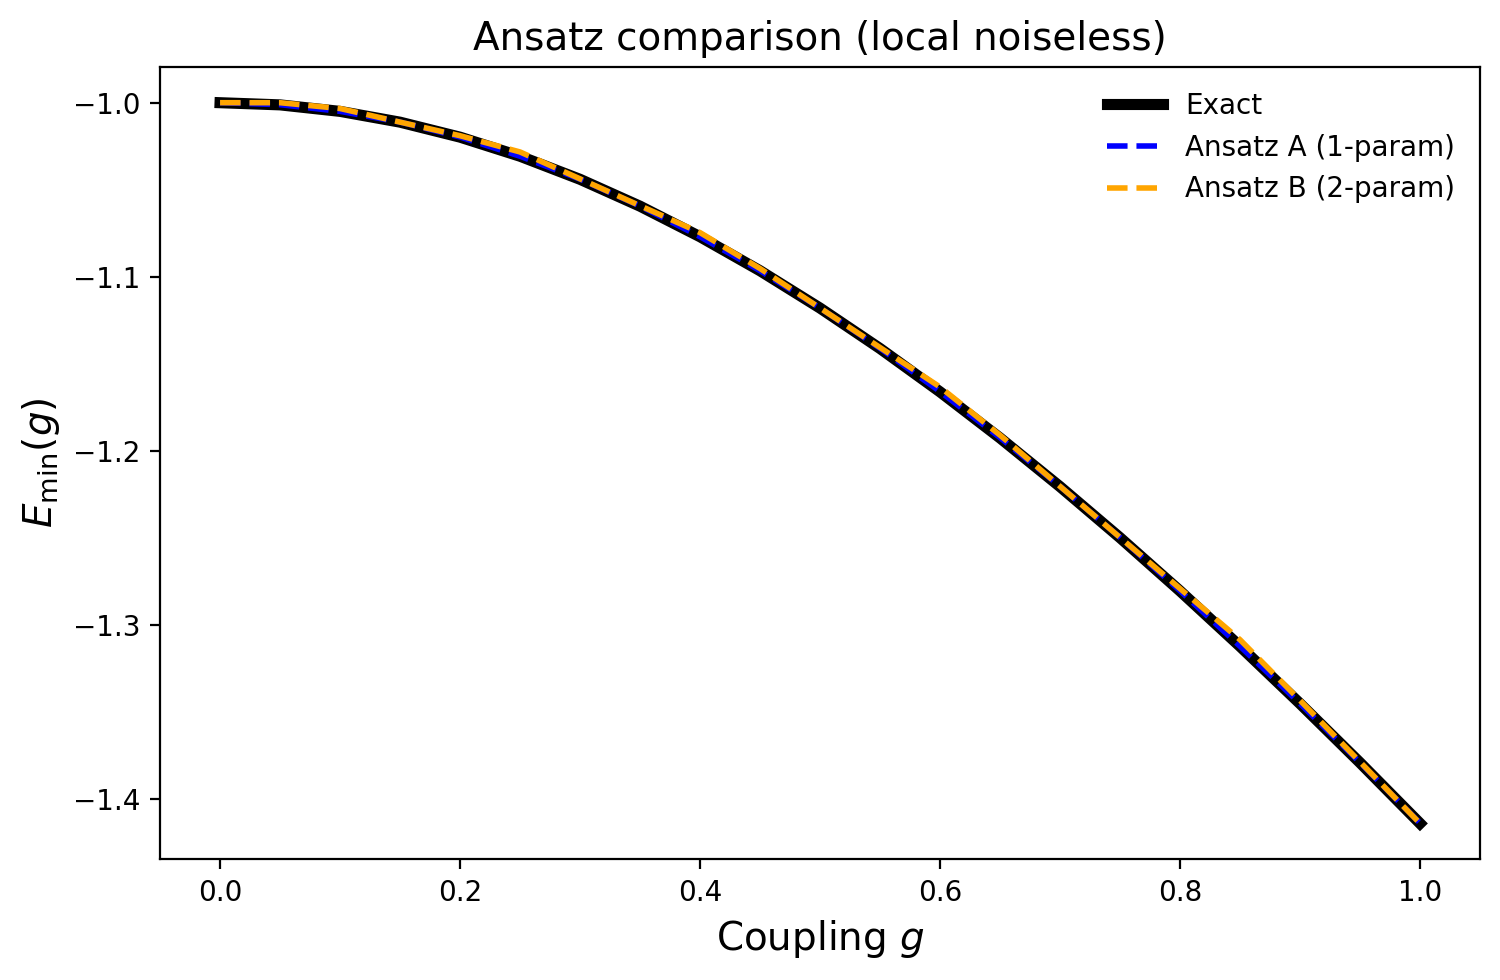

Mean improvement (A - B): -0.0010300318958139179


In [18]:
# Interpolate Ansatz A minima on the same g-grid for a clean comparison
Emin_A_cmp = np.interp(g_grid_cmp, g_grid, Emin_A)
E_exact_cmp = np.interp(g_grid_cmp, g_grid, E_exact_grid)

plt.figure(figsize=(7.6, 5.0), dpi=200)
plt.plot(g_grid_cmp, E_exact_cmp, lw=4, ls="-", color=COLOR_EX, label="Exact")

plt.plot(g_grid_cmp, Emin_A_cmp, lw=2, ls='--', color=COLOR_A, label="Ansatz A (1-param)")
# plt.scatter(g_grid_cmp, Emin_A_cmp, s=70, color=COLOR_A)

plt.plot(g_grid_cmp, Emin_B, lw=2, ls='--', color=COLOR_B, label="Ansatz B (2-param)")
# plt.scatter(g_grid_cmp, Emin_B, s=70, color=COLOR_B)

plt.xlabel(r"Coupling $g$", fontsize=14)
plt.ylabel(r"$E_{\min}(g)$", fontsize=14)
plt.title("Ansatz comparison (local noiseless)", fontsize=14)
plt.legend(frameon=False)
plt.tight_layout()
savefig("03_local_Emin_vs_g_ansatz_compare.png")
plt.show()

print("Mean improvement (A - B):", float(np.mean(Emin_A_cmp - Emin_B)))

## Local noise study (Aer)

Emulating hardware-like effects by adding depolarizing noise (and a small readout error) and estimating expectation values from sampled counts.


In [19]:
# ============================
# Local noise model (AerSimulator) + sampled expectation values
# ============================

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

def expvals_from_counts_Zbasis(counts: dict):
    # Return <Z on q0>, <Z on q1>, and <ZZ> from Z-basis measurement counts.
    shots = sum(counts.values())
    Ez0 = Ez1 = Ezz = 0.0
    for bitstr, c in counts.items():
        b1 = int(bitstr[-2])  # q1
        b0 = int(bitstr[-1])  # q0
        z0 = +1.0 if b0 == 0 else -1.0
        z1 = +1.0 if b1 == 0 else -1.0
        Ez0 += z0 * c
        Ez1 += z1 * c
        Ezz += (z1 * z0) * c
    return float(Ez0/shots), float(Ez1/shots), float(Ezz/shots)

def noisy_expectations_A(theta: float, backend: AerSimulator, shots: int = 4000, seed: int = 123):
    # Return noisy estimates of <ZI>, <IZ>, <XX> for Ansatz A at given theta.
    qc = ansatz_A(theta)

    # ZI and IZ (measure in Z basis)
    qc_Z = qc.copy()
    qc_Z.measure_all()
    counts_Z = backend.run(qc_Z, shots=shots, seed_simulator=seed).result().get_counts()
    Ez0, Ez1, _ = expvals_from_counts_Zbasis(counts_Z)
    exp_ZI = Ez0
    exp_IZ = Ez1

    # XX: rotate both qubits with H so X -> Z
    qc_XX = qc.copy()
    qc_XX.h(0); qc_XX.h(1)
    qc_XX.measure_all()
    counts_XX = backend.run(qc_XX, shots=shots, seed_simulator=seed+1).result().get_counts()
    _, _, Ezz = expvals_from_counts_Zbasis(counts_XX)
    exp_XX = Ezz

    return exp_ZI, exp_IZ, exp_XX

def energy_A_noisy(theta: float, g: float, backend: AerSimulator, wc: float = 1.0, we: float = 1.0,
                   shots: int = 4000, seed: int = 123):
    exp_ZI, exp_IZ, exp_XX = noisy_expectations_A(theta, backend=backend, shots=shots, seed=seed)
    return float(0.5*wc*exp_ZI + 0.5*we*exp_IZ + g*exp_XX)

# --- noise model ---
p1 = 0.01  # 1-qubit depolarizing
p2 = 0.02  # 2-qubit depolarizing (CX)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['ry'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])

# small readout error
ro_p = 0.02
ro_err = ReadoutError([[1-ro_p, ro_p], [ro_p, 1-ro_p]])
noise_model.add_all_qubit_readout_error(ro_err)

noisy_backend = AerSimulator(noise_model=noise_model)

# --- compare Emin(g): ideal vs noisy (coarse grid) ---
g_grid_n = np.linspace(0.0, 1.0, 13)
theta_grid_n = np.linspace(0, 2*np.pi, 61)
shots = 4000

Emin_noisy = np.zeros_like(g_grid_n)
for i, g in enumerate(g_grid_n):
    Evals = np.array([energy_A_noisy(th, g=g, backend=noisy_backend, wc=wc, we=we, shots=shots, seed=10+i)
                      for th in theta_grid_n])
    Emin_noisy[i] = float(np.min(Evals))

Emin_ideal = np.interp(g_grid_n, g_grid, Emin_A)
E_exact_n  = np.array([exact_ground_energy(g, wc=wc, we=we)[0] for g in g_grid_n])


Saved: figures/04_local_noisy_vs_ideal_Emin.png


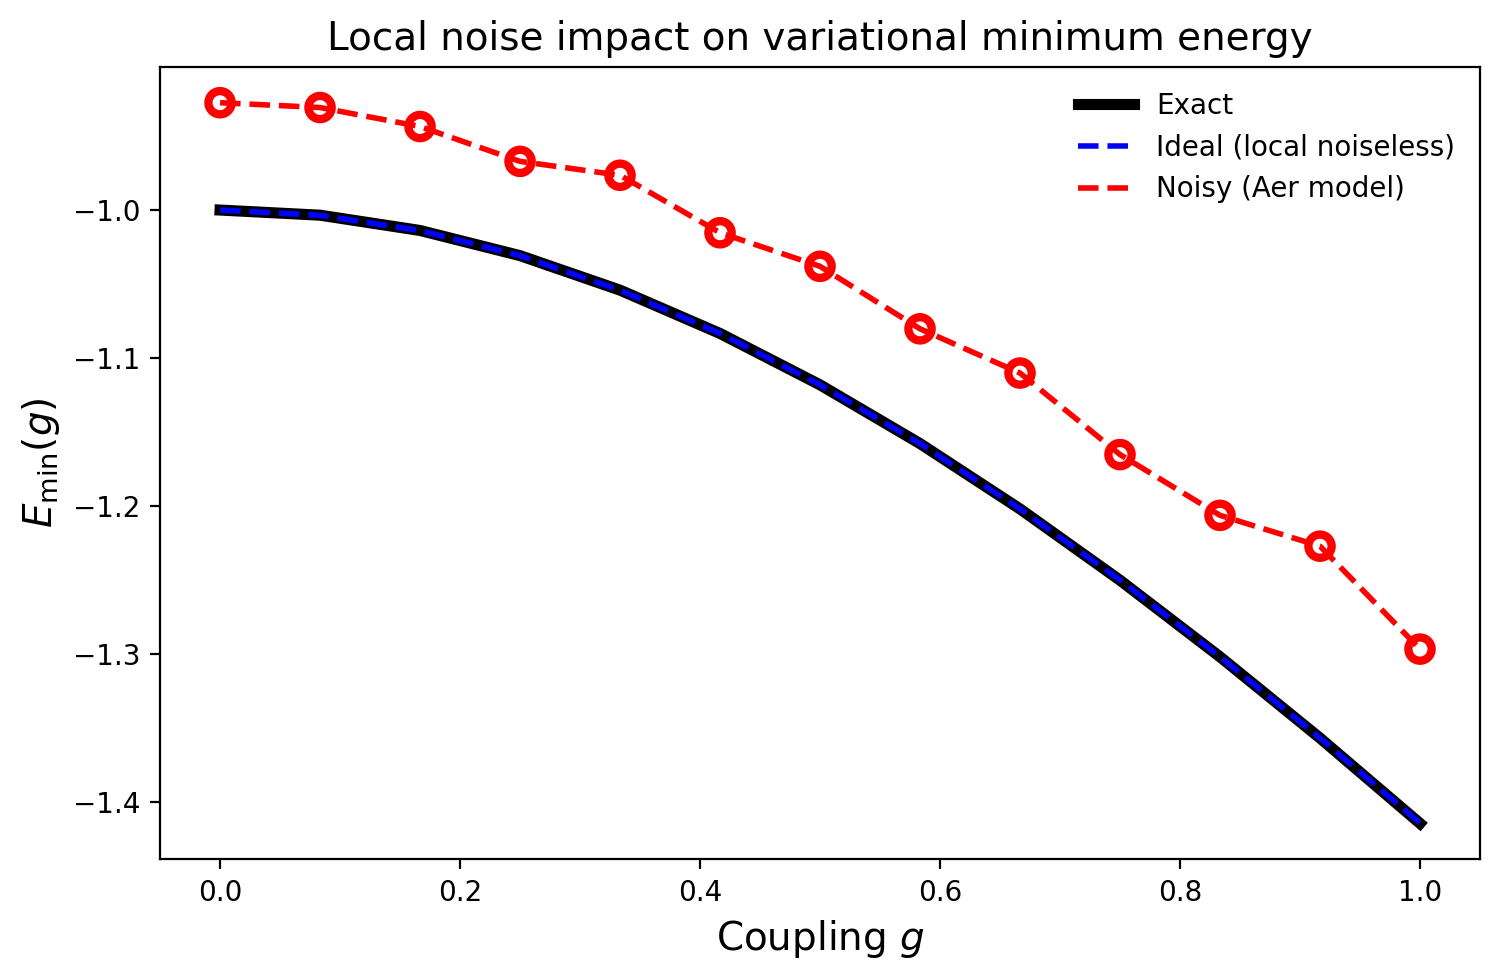

In [22]:
plt.figure(figsize=(7.6, 5.0), dpi=200)
plt.plot(g_grid_n, E_exact_n, lw=4, ls="-", color=COLOR_EX, label="Exact")
plt.plot(g_grid_n, Emin_ideal, lw=2, ls='--', color=COLOR_A, label="Ideal (local noiseless)")
plt.plot(g_grid_n, Emin_noisy, lw=2, ls='--', color=COLOR_HW, label="Noisy (Aer model)")

plt.scatter(g_grid_n, Emin_noisy, s=70, edgecolor=COLOR_HW, facecolor="None", lw=3)

plt.xlabel(r"Coupling $g$", fontsize=14)
plt.ylabel(r"$E_{\min}(g)$", fontsize=14)
plt.title("Local noise impact on variational minimum energy", fontsize=14)
plt.legend(frameon=False)
plt.tight_layout()
savefig("04_local_noisy_vs_ideal_Emin.png")
plt.show()

## IBM Quantum hardware benchmarking

We run the same ansatz state on a real IBM backend and benchmark the energy against exact diagonalization.

Two modes:
- **Raw:** `resilience_level=0`, no dynamical decoupling
- **Mitigated:** `resilience_level=1` + dynamical decoupling (XY4)

Set `already_computed=True` to load saved results from disk (recommended for a public repo).


In [23]:
# ============================
# IBM Runtime setup
# ============================

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as IBMEstimator
from qiskit_ibm_runtime import EstimatorOptions

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.utils import RuntimeEncoder, RuntimeDecoder

# If already saved account, this would work without a token:
# service = QiskitRuntimeService(channel="ibm_cloud", instance="QC_san")
# backend = service.backend("ibm_fez")

BACKEND_NAME = "ibm_fez"
INSTANCE_NAME = "QC_san"

service = QiskitRuntimeService(channel="ibm_cloud", instance=INSTANCE_NAME)
backend = service.backend(name=BACKEND_NAME)

print("Backend:", backend.name)
print("Num qubits:", backend.num_qubits)

st = backend.status()
print("Status:", st.status_msg, "| Pending jobs:", st.pending_jobs)


Backend: ibm_fez
Num qubits: 156
Status: active | Pending jobs: 0


In [24]:
# ============================
# Hardware run helper (EstimatorV2 framework) + disk IO
# ============================

def run_hw_point(theta: float, g: float, wc: float = 1.0, we: float = 1.0,
                 resilience_level: int = 1, dd_enable: bool = True):
    # Runs ansatz_A(theta) and returns:
    # exp_ZI, exp_IZ, exp_XX, E_hw, job_id, job_time_seconds

    qc = ansatz_A(theta)

    operators = [Pauli(s) for s in OP_NAMES]

    pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
    qc_t = pass_manager.run(qc)
    operators_t_list = [op.apply_layout(qc_t.layout) for op in operators]

    options = EstimatorOptions()
    options.resilience_level = int(resilience_level)
    options.dynamical_decoupling.enable = bool(dd_enable)
    options.dynamical_decoupling.sequence_type = "XY4"

    estimator = IBMEstimator(backend, options=options)
    job = estimator.run([(qc_t, operators_t_list)])
    job_id = job.job_id()

    job2 = service.job(job_id)
    result = job2.result()
    evs = result[0].data.evs

    exp_ZI_hw, exp_IZ_hw, exp_XX_hw = [float(x) for x in evs]
    E_hw = float(0.5*wc*exp_ZI_hw + 0.5*we*exp_IZ_hw + g*exp_XX_hw)

    job_time = np.nan
    try:
        m = job2.metrics()
        usage = m.get("usage", {})
        if isinstance(usage, dict) and "quantum_seconds" in usage:
            job_time = float(usage["quantum_seconds"])
        elif isinstance(usage, dict) and "seconds" in usage:
            job_time = float(usage["seconds"])
        else:
            job_time = float(job2.usage())
    except Exception:
        pass

    print(f"job_id={job_id} | g={g:.2f} theta/pi={theta/np.pi:.3f} | RL={resilience_level} DD={dd_enable} | usage={job_time}s")
    return exp_ZI_hw, exp_IZ_hw, exp_XX_hw, E_hw, job_id, job_time


def save_hw_run(run_dir: str, idx: int, job_id: str, g: float, theta: float,
                wc: float, we: float, RL: int, DD, job_time: float, result_obj):
    # Save a single job metadata + PrimitiveResult to disk
    os.makedirs(run_dir, exist_ok=True)

    job_dict = dict(job_id=job_id, g=float(g), theta=float(theta), wc=float(wc), we=float(we),
                    RL=int(RL), DD=DD, time=float(job_time))
    with open(os.path.join(run_dir, f"job_{idx}.json"), "w") as f:
        json.dump(job_dict, f, indent=2)

    with open(os.path.join(run_dir, f"result_{idx}.json"), "w") as f:
        json.dump(result_obj, f, cls=RuntimeEncoder)

def load_hw_point_from_disk(job_file: str, res_file: str):
    # Load one saved hardware point from disk
    with open(job_file, "r") as f:
        job_dict = json.load(f)

    with open(res_file, "r") as f:
        result = json.load(f, cls=RuntimeDecoder)

    evs = result[0].data.evs
    exp_ZI_hw, exp_IZ_hw, exp_XX_hw = [float(x) for x in evs]
    g = float(job_dict["g"])
    wc = float(job_dict["wc"])
    we = float(job_dict["we"])

    E_hw = float(0.5*wc*exp_ZI_hw + 0.5*we*exp_IZ_hw + g*exp_XX_hw)
    job_time = float(job_dict.get("time", np.nan))
    return exp_ZI_hw, exp_IZ_hw, exp_XX_hw, E_hw, job_dict["job_id"], job_time, job_dict


In [25]:
# ============================
# Hardware g-grid benchmark: Raw vs Mitigated
# ============================

g_points = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

theta_points = np.array([float(np.interp(g, g_grid, theta_star_A)) for g in g_points])

E_exact_points = np.array([exact_ground_energy(g, wc=wc, we=we)[0] for g in g_points])
E_local_points = np.array([energy_A_local(theta_points[i], g_points[i], wc=wc, we=we) for i in range(len(g_points))])

print(f"{'g':>6} | {'theta*':>10} | {'theta*/pi':>10} | {'E_exact':>12} | {'E_local':>12}")
print("-"*62)
for i in range(len(g_points)):
    print(f"{g_points[i]:6.2f} | {theta_points[i]:10.4f} | {theta_points[i]/np.pi:10.4f} | "
          f"{E_exact_points[i]:12.6f} | {E_local_points[i]:12.6f}")

already_computed = True

RAW_DIR = os.path.join("ibm_runs", "light_matter_g_grid_raw")
MIT_DIR = os.path.join("ibm_runs", "light_matter_g_grid_mitigated")

E_hw_raw = np.zeros_like(g_points)
T_hw_raw = np.zeros_like(g_points)

E_hw_mit = np.zeros_like(g_points)
T_hw_mit = np.zeros_like(g_points)

job_ids_raw = []
job_ids_mit = []

# --- Raw runs ---
for i, (g, th) in enumerate(zip(g_points, theta_points)):
    if already_computed:
        expZI, expIZ, expXX, Ehw, jid, tsec, meta = load_hw_point_from_disk(
            os.path.join(RAW_DIR, f"job_{i}.json"),
            os.path.join(RAW_DIR, f"result_{i}.json"),
        )
    else:
        expZI, expIZ, expXX, Ehw, jid, tsec = run_hw_point(th, g, wc=wc, we=we, resilience_level=0, dd_enable=False)
        job_obj = service.job(jid)
        save_hw_run(RAW_DIR, i, jid, g, th, wc, we, RL=0, DD=False, job_time=tsec, result_obj=job_obj.result())

    E_hw_raw[i] = Ehw
    T_hw_raw[i] = tsec
    job_ids_raw.append(jid)

# --- Mitigated runs ---
for i, (g, th) in enumerate(zip(g_points, theta_points)):
    if already_computed:
        expZI, expIZ, expXX, Ehw, jid, tsec, meta = load_hw_point_from_disk(
            os.path.join(MIT_DIR, f"job_{i}.json"),
            os.path.join(MIT_DIR, f"result_{i}.json"),
        )
    else:
        expZI, expIZ, expXX, Ehw, jid, tsec = run_hw_point(th, g, wc=wc, we=we, resilience_level=1, dd_enable=True)
        job_obj = service.job(jid)
        save_hw_run(MIT_DIR, i, jid, g, th, wc, we, RL=1, DD="XY4", job_time=tsec, result_obj=job_obj.result())

    E_hw_mit[i] = Ehw
    T_hw_mit[i] = tsec
    job_ids_mit.append(jid)

print("Raw job_ids:", job_ids_raw)
print("Mitigated job_ids:", job_ids_mit)


     g |     theta* |  theta*/pi |      E_exact |      E_local
--------------------------------------------------------------
  0.00 |     3.1416 |     1.0000 |    -1.000000 |    -1.000000
  0.20 |     3.3510 |     1.0667 |    -1.019804 |    -1.019730
  0.40 |     3.5256 |     1.1222 |    -1.077033 |    -1.077026
  0.60 |     3.6652 |     1.1667 |    -1.166190 |    -1.166025
  0.80 |     3.8048 |     1.2111 |    -1.280625 |    -1.280540
  1.00 |     3.9095 |     1.2444 |    -1.414214 |    -1.413998
Raw job_ids: ['d5il007ea9qs7393ckkg', 'd5il0e4pe0pc73ankkjg', 'd5il1h767pic7386jcp0', 'd5il1kqgim5s73aj5nn0', 'd5il1p4pe0pc73ankmc0', 'd5il1sn67pic7386jd7g']
Mitigated job_ids: ['d5ikom767pic7386j1rg', 'd5ikor4pe0pc73ankaog', 'd5ikovqgim5s73aj5cqg', 'd5ikp4n67pic7386j29g', 'd5ikpbcpe0pc73ankb80', 'd5ikpif67pic7386j2o0']


Saved: figures/05_ibm_energy_exact_local_hw.png


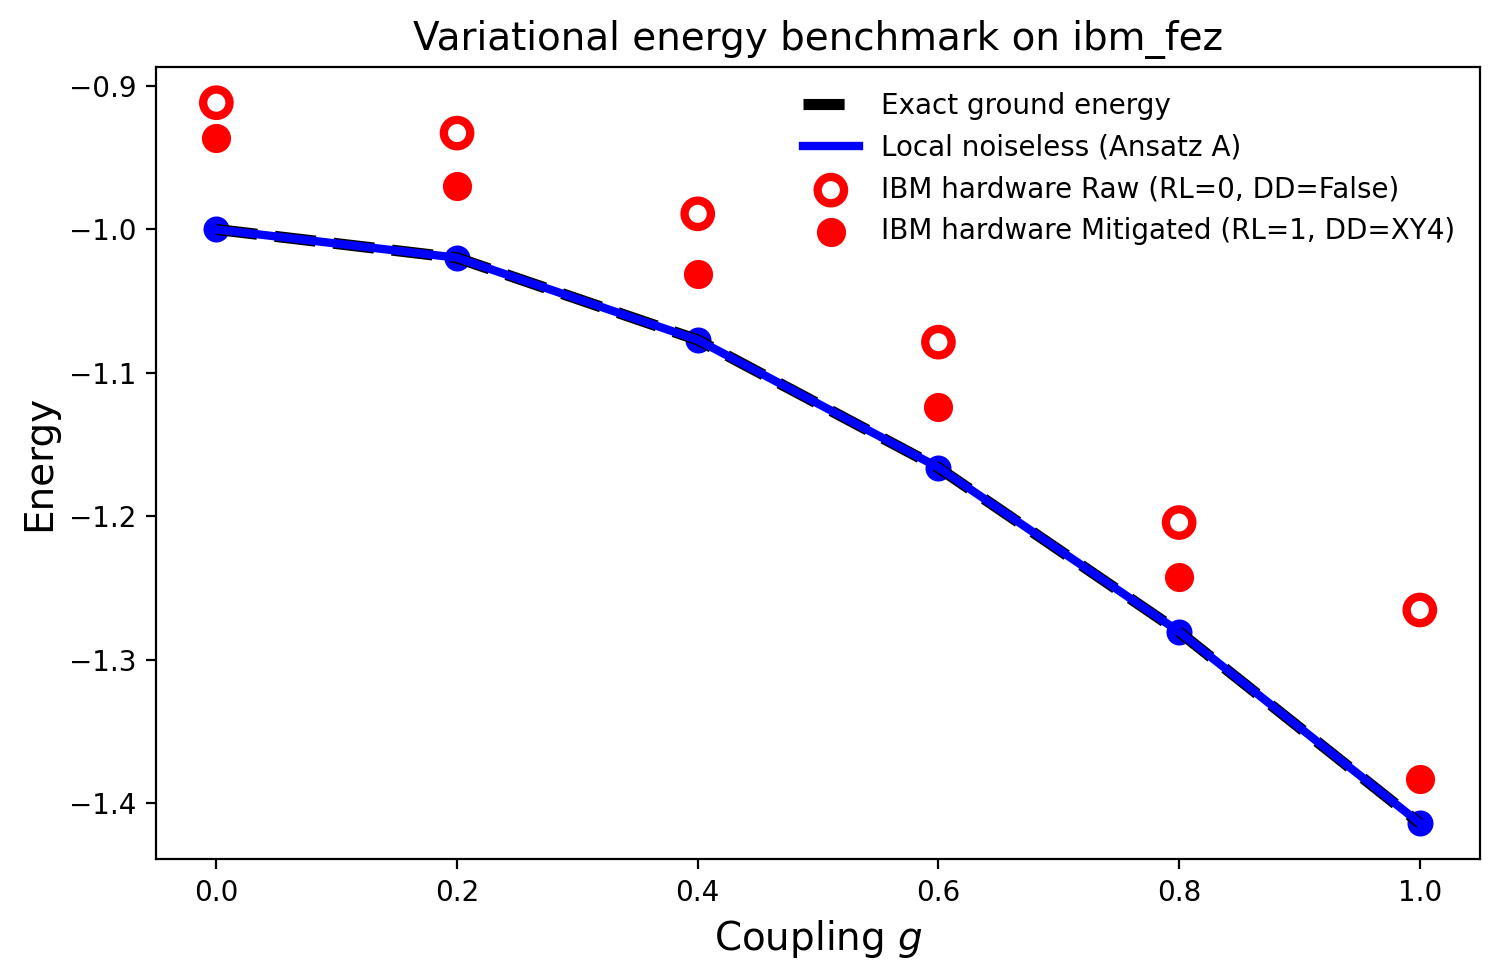

Saved: figures/06_ibm_deviation_vs_g.png


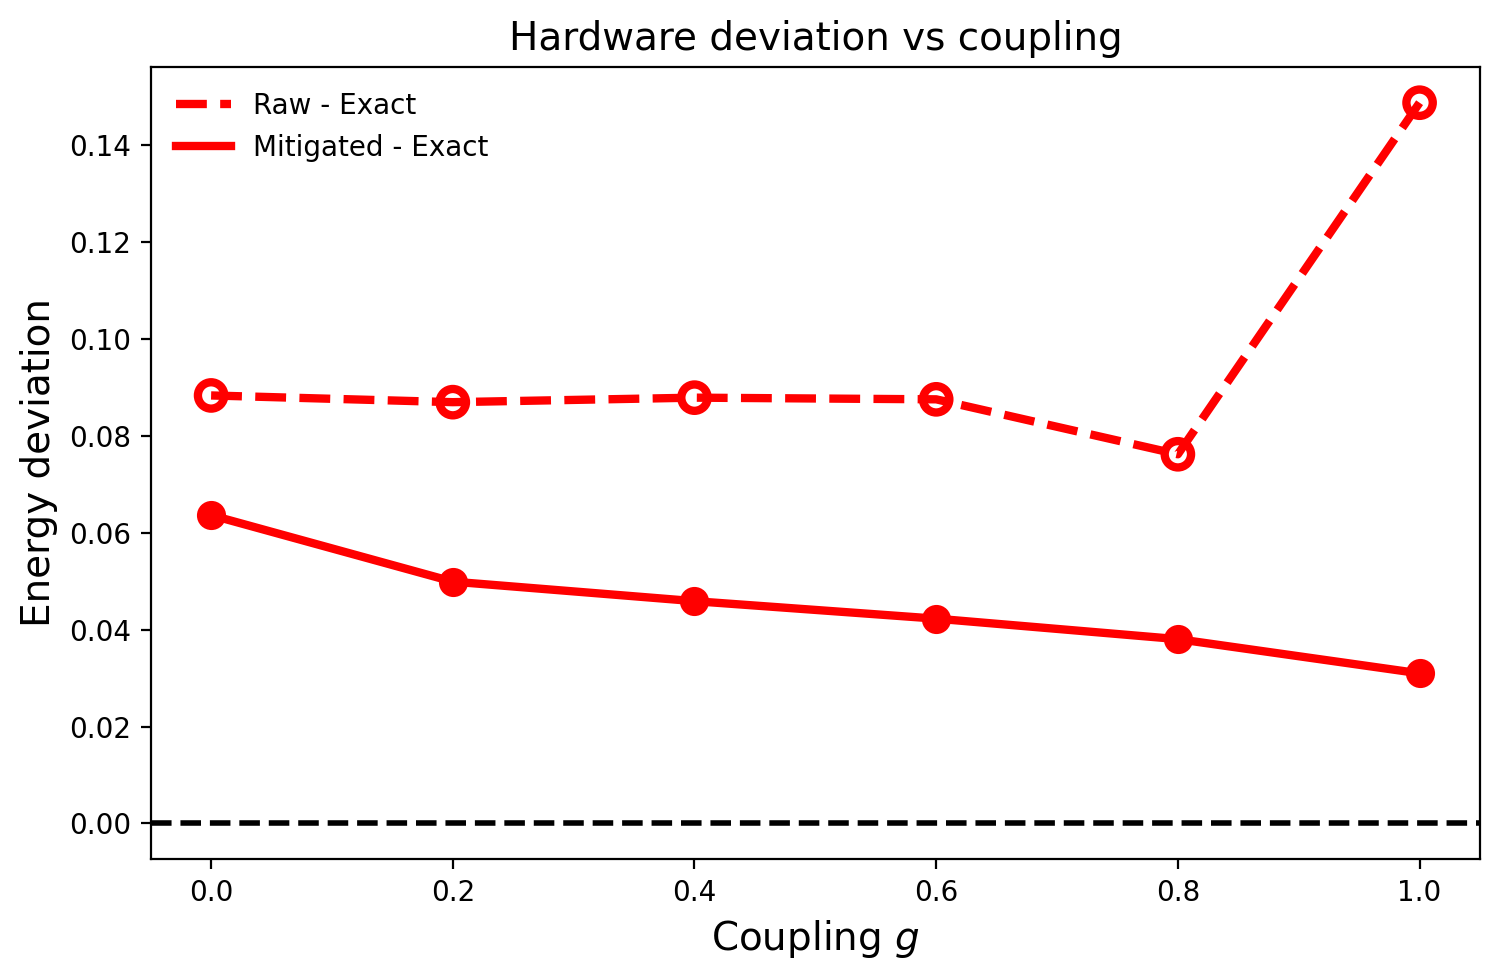

Saved: figures/07_ibm_percent_error_vs_g.png


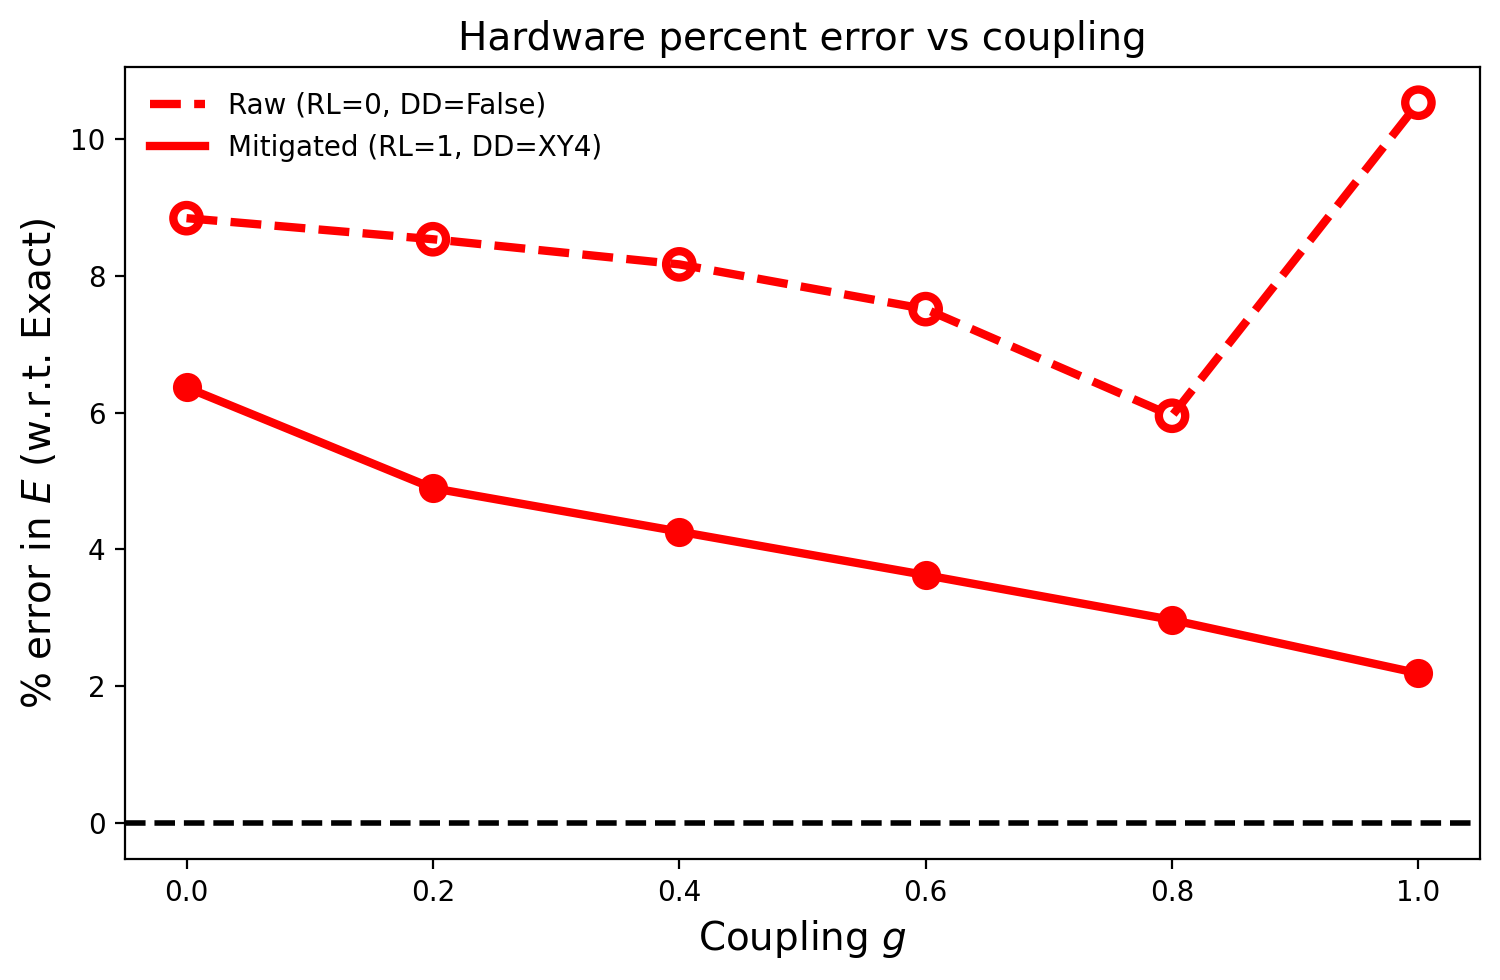

Saved: figures/08_ibm_runtime_raw_vs_mitigated.png


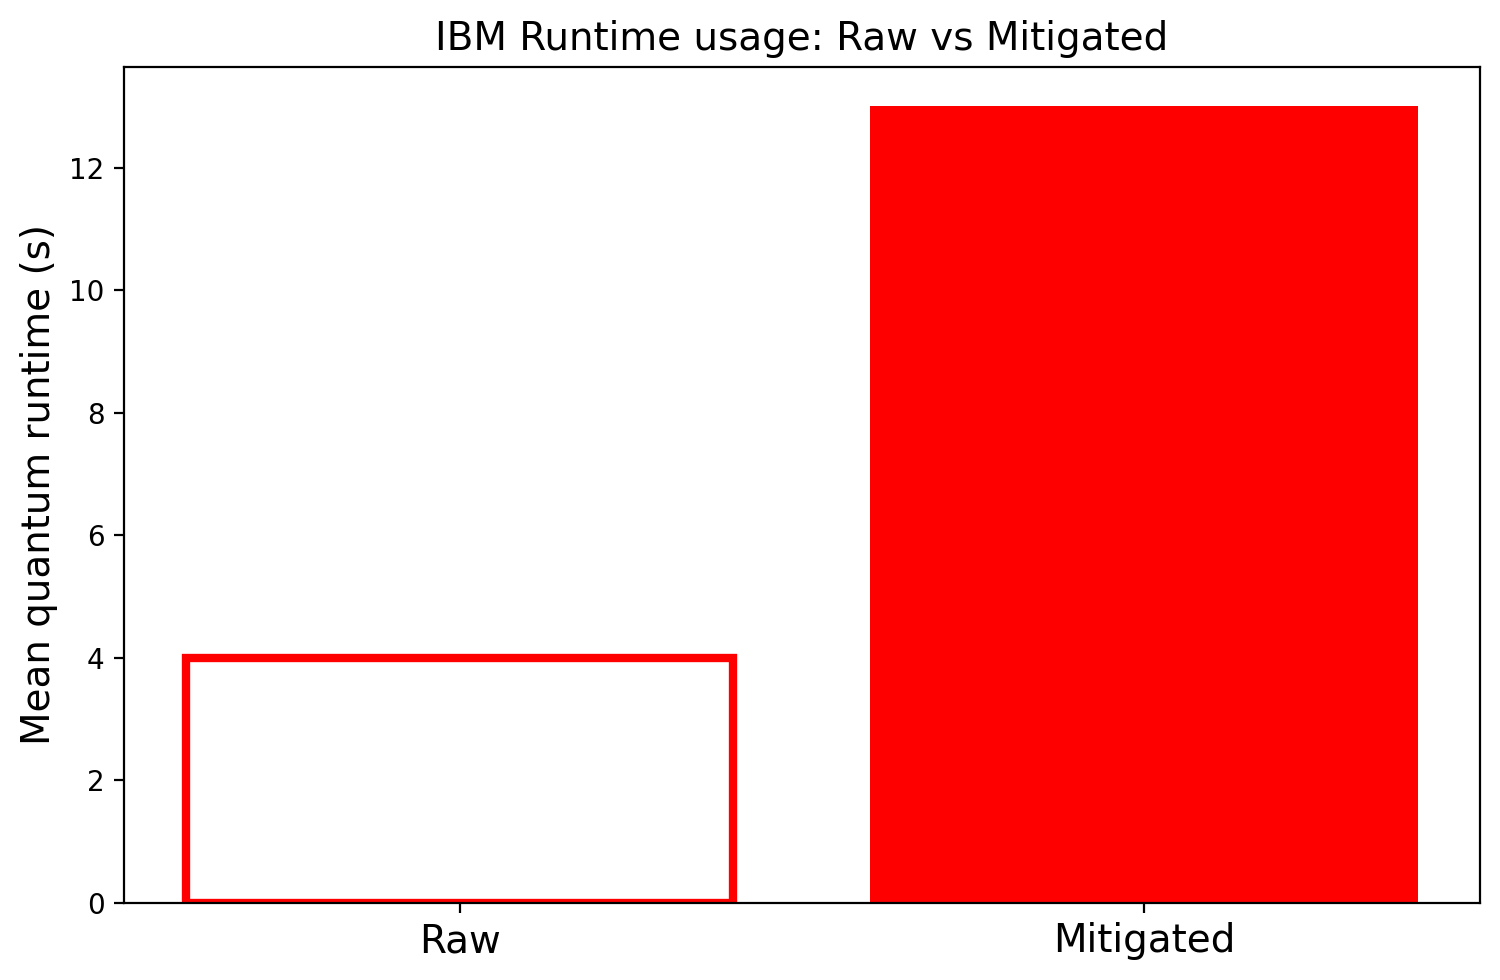

Mean runtime raw      = 4.000 s
Mean runtime mitigated= 13.000 s


In [27]:
# ============================
# Plots: energies, deviations, % error, runtime bars
# ============================

plt.figure(figsize=(7.6, 5.0), dpi=200)

plt.plot(g_points, E_exact_points, lw=4, ls="--", color=COLOR_EX, label="Exact ground energy")
plt.plot(g_points, E_local_points, lw=3, color=COLOR_A, label="Local noiseless (Ansatz A)")
plt.scatter(g_points, E_local_points, s=70, color=COLOR_A)

plt.scatter(g_points, E_hw_raw, s=90, edgecolor=COLOR_HW, facecolor="None", lw=3,
            label=r"IBM hardware Raw (RL=0, DD=False)")
plt.scatter(g_points, E_hw_mit, s=90, color=COLOR_HW,
            label=r"IBM hardware Mitigated (RL=1, DD=XY4)")

plt.xlabel(r"Coupling $g$", fontsize=14)
plt.ylabel("Energy", fontsize=14)
plt.title(f"Variational energy benchmark on {BACKEND_NAME}", fontsize=14)
plt.legend(frameon=False)
plt.tight_layout()
savefig("05_ibm_energy_exact_local_hw.png")
plt.show()

err_raw = E_hw_raw - E_exact_points
err_mit = E_hw_mit - E_exact_points

plt.figure(figsize=(7.6, 5.0), dpi=200)

plt.plot(g_points, err_raw, lw=3, color=COLOR_HW, ls="--", label="Raw - Exact")
plt.scatter(g_points, err_raw, s=90, edgecolor=COLOR_HW, facecolor="None", lw=3)

plt.plot(g_points, err_mit, lw=3, color=COLOR_HW, ls="-", label="Mitigated - Exact")
plt.scatter(g_points, err_mit, s=90, color=COLOR_HW)

plt.axhline(0.0, lw=2, ls="--", color=COLOR_EX)
plt.xlabel(r"Coupling $g$", fontsize=14)
plt.ylabel("Energy deviation", fontsize=14)
plt.title("Hardware deviation vs coupling", fontsize=14)
plt.legend(frameon=False)
plt.tight_layout()
savefig("06_ibm_deviation_vs_g.png")
plt.show()

eps = 1e-12
pct_raw = 100.0 * err_raw / (np.abs(E_exact_points) + eps)
pct_mit = 100.0 * err_mit / (np.abs(E_exact_points) + eps)

plt.figure(figsize=(7.6, 5.0), dpi=200)

plt.plot(g_points, pct_raw, lw=3, color=COLOR_HW, ls="--", label="Raw (RL=0, DD=False)")
plt.scatter(g_points, pct_raw, s=90, edgecolor=COLOR_HW, facecolor="None", lw=3)

plt.plot(g_points, pct_mit, lw=3, color=COLOR_HW, ls="-", label="Mitigated (RL=1, DD=XY4)")
plt.scatter(g_points, pct_mit, s=90, color=COLOR_HW)

plt.axhline(0.0, lw=2, ls="--", color=COLOR_EX)
plt.xlabel(r"Coupling $g$", fontsize=14)
plt.ylabel(r"% error in $E$ (w.r.t. Exact)", fontsize=14)
plt.title("Hardware percent error vs coupling", fontsize=14)
plt.legend(frameon=False)
plt.tight_layout()
savefig("07_ibm_percent_error_vs_g.png")
plt.show()

mean_raw = float(np.nanmean(T_hw_raw))
mean_mit = float(np.nanmean(T_hw_mit))

plt.figure(figsize=(7.6, 5.0), dpi=200)
x = np.array([0, 1])

# Raw (left): no fill, red border
plt.bar(x[0], mean_raw, facecolor="None", edgecolor=COLOR_HW, linewidth=3)

# Mitigated (right): red fill, no border
plt.bar(x[1], mean_mit, color=COLOR_HW, edgecolor="None", linewidth=0)

plt.xticks(x, ["Raw", "Mitigated"], fontsize=14)
plt.ylabel("Mean quantum runtime (s)", fontsize=14)
plt.title("IBM Runtime usage: Raw vs Mitigated", fontsize=14)
plt.tight_layout()
savefig("08_ibm_runtime_raw_vs_mitigated.png")
plt.show()

print(f"Mean runtime raw      = {mean_raw:.3f} s")
print(f"Mean runtime mitigated= {mean_mit:.3f} s")
